<a href="https://colab.research.google.com/github/nicklausnathanieltiu23p76078-wq/PythonforDataScienceandAI_FinalProject_Group16/blob/main/FakeNews_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Group's Student IDs:
- 23229051 - Yotaro Nawfal Ramadhan
- 23229537 - Edbert Lifaustin Arianto
- 23229587 - Nicklaus Nathaniel Brahmadarmaputra Purnomo


---


In this era of digitalization, misinformation just gets easier and easier to spread online. Some news seems so real to us that most people wouldn't bother about fact checking.

This project intends to automate the process of validating and filtering whether a news article is real or fake by using NLP.


In this project, we use:

*   Dataset: 'GonzaloA/fake_news'
*   Model: 'jaranohaal/distilbert-base-uncased-finetuned-fake-news'
*   Library: Hugging Face 'transformers' & 'datasets'
*   Evaluatuion method: Accuracy test, F1 score, confusion matrix

# Explanatory Data Analysis

In [ ]:
!pip install datasets pandas numpy matplotlib wordcloud seaborn --quiet

In [ ]:
from datasets import load_dataset
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

In [ ]:
dataset = load_dataset("GonzaloA/fake_news", split="train", streaming=True)
df = pd.DataFrame(itertools.islice(dataset, 8117))
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,Unnamed: 0,title,text,label
0,0,‘Maury’ Show Official Facebook Posts F*CKED U...,Maury is perhaps one of the trashiest shows on...,0
1,1,Trump’s Favorite News Channel Tries To Soothe...,"Yesterday, after the father of one of the UCLA...",0
2,2,"Russia warns Iraq, Kurds not to destabilize Mi...",MOSCOW (Reuters) - Russia on Wednesday warned ...,1
3,3,WATCH STEVE SCALISE Throw A Strike At The Nati...,"House Majority Whip Steve Scalise (R., La.) th...",0
4,4,Trump Will HATE What Stephen Colbert Just Did...,It can be said that Late Show host Stephen Col...,0


In [ ]:
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8117 non-null   int64 
 1   title       8117 non-null   object
 2   text        8117 non-null   object
 3   label       8117 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 253.8+ KB


,Unnamed: 0,title,text,label
count,8117.000000,8117,8117,8117.000000
unique,NaN,8058,8117,NaN
top,NaN,no title,BEIJING (Reuters) - China supports a peaceful ...,NaN
freq,NaN,35,1,NaN
mean,4058.000000,NaN,NaN,0.532586
std,2343.320401,NaN,NaN,0.498968
min,0.000000,NaN,NaN,0.000000
25%,2029.000000,NaN,NaN,0.000000
50%,4058.000000,NaN,NaN,1.000000
75%,6087.000000,NaN,NaN,1.000000


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


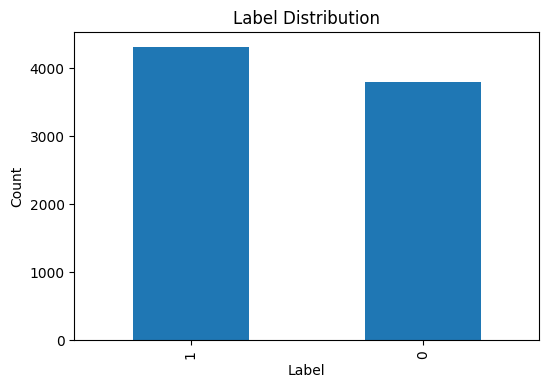

In [ ]:
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

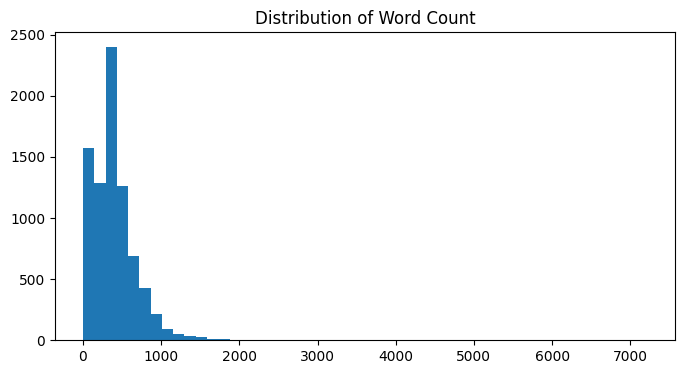

In [ ]:
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
plt.hist(df["word_count"], bins=50)
plt.title("Distribution of Word Count")
plt.show()

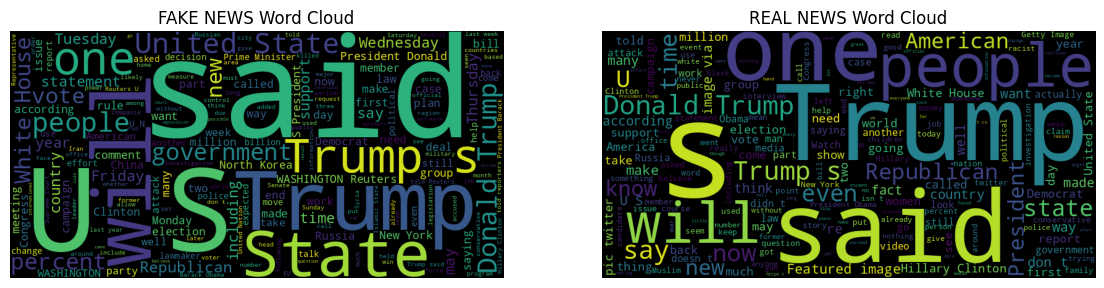

In [ ]:
fake_text = " ".join(df[df['label']==1]["text"].astype(str).tolist())
true_text = " ".join(df[df['label']==0]["text"].astype(str).tolist())

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800, height=400).generate(fake_text))
plt.title("FAKE NEWS Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800, height=400).generate(true_text))
plt.title("REAL NEWS Word Cloud")
plt.axis("off")
plt.show()

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
def clean(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z ]", "", text)
    return text

words = " ".join(df["text"].astype(str).apply(clean)).split()
counts = Counter(words).most_common(20)
counts

[('the', 183623),
 ('to', 96919),
 ('of', 80095),
 ('a', 74170),
 ('and', 73835),
 ('in', 63211),
 ('that', 42709),
 ('on', 34732),
 ('for', 31505),
 ('is', 30011),
 ('s', 29593),
 ('said', 24184),
 ('he', 23404),
 ('it', 22822),
 ('trump', 22133),
 ('with', 21215),
 ('was', 20410),
 ('as', 18961),
 ('by', 17319),
 ('his', 17156)]

# Training Agent

In [ ]:
!pip install -U transformers

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
from huggingface_hub import login
login()

In [ ]:
# 1. Load dataset
dataset = load_dataset("GonzaloA/fake_news")

Repo card metadata block was not found. Setting CardData to empty.


data/train-00000-of-00001.parquet:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24353 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [ ]:
# 2. Load tokenizer
model_name = "jaranohaal/distilbert-base-uncased-finetuned-fake-news"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# 3. Tokenizing function
def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [ ]:
# 4. Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# 5. Metrics for evaluation
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels)

    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"]
    }

In [ ]:
# 6. Training arguments
training_args = TrainingArguments(
    output_dir="test-finetune",
    save_strategy="epoch",
    learning_rate=2e-5,      # tuning
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,      # kamu bisa ubah jadi 3-5
    weight_decay=0.01,
    logging_dir="logs",
)

In [ ]:
# 7. Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2628149662.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 8. Train model
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: edbertarianto (edbertarianto-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.037300
1000,0.025700
1500,0.032900
2000,0.038200
2500,0.039700
3000,0.022300
3500,0.008900
4000,0.006200
4500,0.011800
5000,0.007800


TrainOutput(global_step=6090, training_loss=0.020515382289886475, metrics={'train_runtime': 1176.0343, 'train_samples_per_second': 41.415, 'train_steps_per_second': 5.178, 'total_flos': 3225978559469568.0, 'train_loss': 0.020515382289886475, 'epoch': 2.0})

In [ ]:
# 9. Evaluate
results = trainer.evaluate()
print(results)

{'eval_loss': 0.06689216941595078, 'eval_accuracy': 0.9897745472465197, 'eval_f1': 0.9904388895288562, 'eval_runtime': 63.4159, 'eval_samples_per_second': 127.996, 'eval_steps_per_second': 16.005, 'epoch': 2.0}


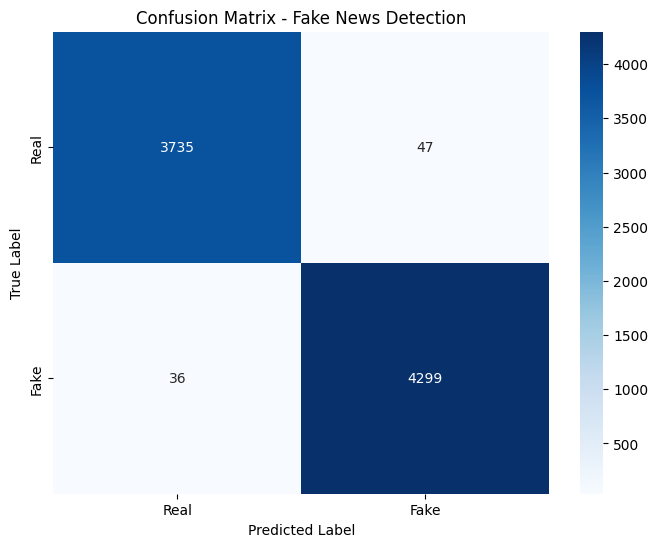

In [ ]:
predictions_output = trainer.predict(tokenized_dataset["test"])

y_preds = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

cm = confusion_matrix(y_true, y_preds)

labels = ['Real', 'Fake']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_preds)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 98.98%


# Conclusion

We successfully fine-tuned the model and increased its accuracy.

Final accuracy: 98.98%



Out of all the data, only 83 were errors.


*   False Negatives: 36
*   False Positives: 47

For our future improvements:


*   Cross testing with other datasets
*   Turn into real-time detection system

